In [3]:
# Download Libraries 
%pip install rasterio
%pip install scikit-image
%pip install -U efficientnet_pytorch
%pip install pytorch-metric-learning
%pip install -q timm
%pip install tqdm
%pip install ipywidgets 
%pip install torchvision
%pip install albumentations


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgr

In [4]:
%pip install "torch>=2.0.0"
%pip install "shapely>=2.0.0"


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Polygon, shape
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

/Users/ix20088/.pyenv/versions/3.8.18/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# Check file or directory is exist
BASE_DIR = "CAM-ForestNetDataset"
SUB_DIR = "Landsat-Grouped"

train_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
val_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/val.csv')
test_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Small-scale oil palm plantation,Smallholder agriculture,3.969016,10.014311,2019,examples/10.014311051001007_3.9690156134753534
1,Rubber plantation,Plantation,3.327125,10.015125,2020,examples/10.015125000000001_3.327125
2,Small-scale oil palm plantation,Smallholder agriculture,3.974799,10.017809,2019,examples/10.017809290629039_3.9747994659212513
3,Small-scale oil palm plantation,Smallholder agriculture,3.974978,10.018571,2019,examples/10.01857144327856_3.9749781904573354
4,Small-scale other plantation,Smallholder agriculture,5.592411,10.025682,2020,examples/10.02568236826734_5.592411467355677


(1, 332, 332)


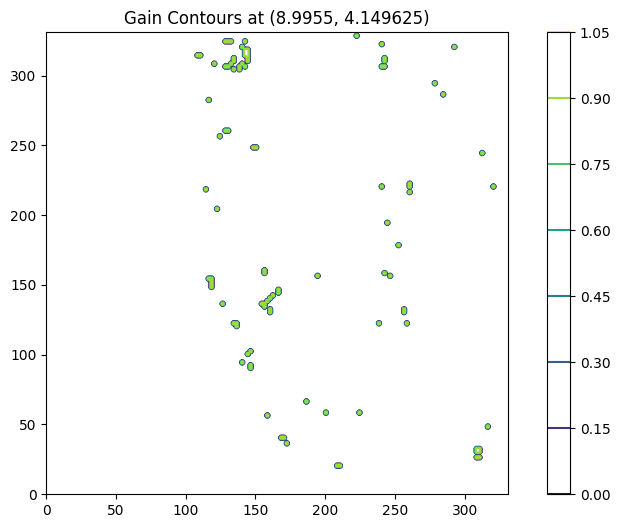

In [7]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/examples/8.9955_4.149625/auxiliary/gain.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array[0], cmap = "viridis", 
            )
plt.title("Gain Contours at (8.9955, 4.149625)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

(332, 332)


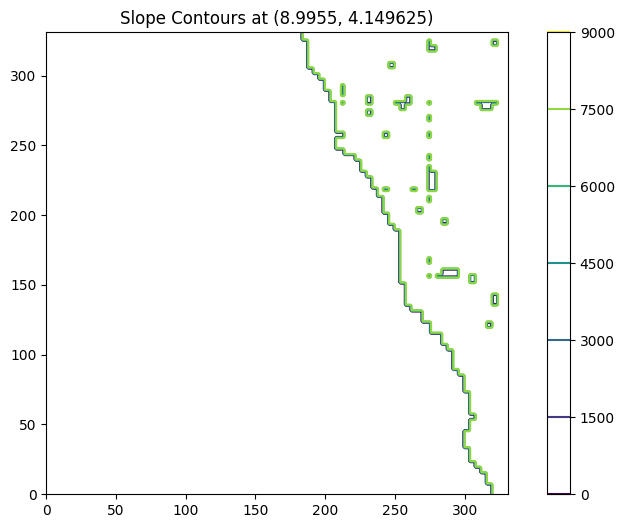

In [8]:
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/examples/8.9955_4.149625/auxiliary/slope.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            )
plt.title("Slope Contours at (8.9955, 4.149625)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

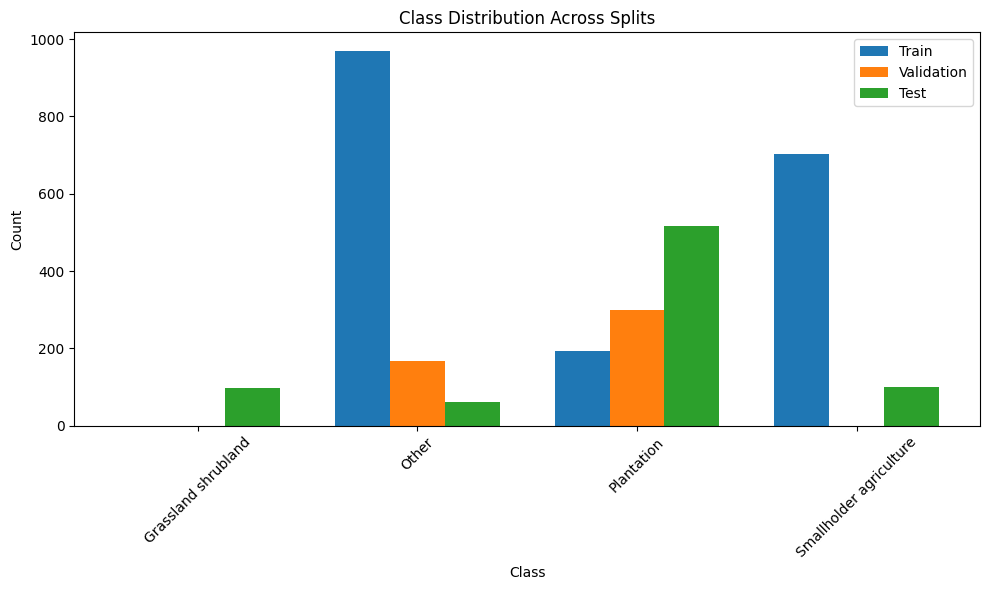

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train, val, test):
    # Get all unique categories from all datasets
    all_categories = list(set(train['merged_label']) | 
                     set(val['merged_label']) | 
                     set(test['merged_label']))
    all_categories.sort()  # Sort alphabetically
    
    # Create positions for bars
    x = np.arange(len(all_categories))
    width = 0.25
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Function to get counts for each split
    def get_counts(df):
        counts = df['merged_label'].value_counts()
        return [counts.get(cat, 0) for cat in all_categories]
    
    # Plot bars for each split
    plt.bar(x - width, get_counts(train), width, label='Train')
    plt.bar(x, get_counts(val), width, label='Validation')
    plt.bar(x + width, get_counts(test), width, label='Test')
    
    # Add labels and formatting
    plt.xticks(x, all_categories, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Across Splits')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with your actual data:
plot_class_distribution(train_df, val_df, test_df)

In [10]:
import glob
import pickle


def load_first_png_image(folder_path):
        png_files = glob.glob(os.path.join(folder_path, '*.png'))

        if not png_files:
            raise FileNotFoundError(f"No PNG files found in {folder_path}")
 
        image = io.imread(png_files[0])
        if image.shape[-1] == 4:  # If RGBA
            image = image[..., :3]  # Take only RGB channels
        return image

class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir='CAM-ForestNetDataset', sub_dir="Landsat-Grouped", transform=None, detailed_labels=False, types="classifier"):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.sub_dir = sub_dir
        self.transform = transform
        if detailed_labels:
            self.label_to_int = {'Oil palm plantation': 0, 'Timber plantation': 1, 'Fruit plantation (e.g. banana)': 2, 'Rubber plantation': 3, 'Other large-scale plantation (e.g. tea, sugarcane)': 4, 'Grassland/Shrubland': 5, 'Small-scale oil palm plantation': 6, 'Small-scale maize plantation': 7, 'Other small-scale agriculture': 8, 'Mining': 9, 'Selective logging': 10, 'Infrastructure': 11, 'Wildfire': 12, 'Hunting': 13, 'Other': 14}
        else:
            self.label_to_int = {'Grassland shrubland':0, 'Other':1, 'Plantation':2, 'Smallholder agriculture':3}
        
        self.types = types

    def __len__(self):
        return len(self.csv)
    
    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]
        
        ## Load the image and auxiliary
        image = load_first_png_image(f'{self.root_dir}/{self.sub_dir}/{folder}/images/visible')
        slope = np.load(f'{self.root_dir}/{self.sub_dir}/{folder}/auxiliary/slope.npy')
          
        ## Get the segmentation map
        with open(f'{self.root_dir}/{self.sub_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)
      
        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)
              
        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
          
        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, slope, merged_label
        else:
            return image, seg, merged_label
 

In [11]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

In [12]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [13]:

train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR)
val_dataset = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR)
test_dataset = ForestDataset( csv_file_to_df=test_df, root_dir=BASE_DIR, sub_dir=SUB_DIR)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [14]:
dataiter = iter(trainloader)
images, seg, slope, labels = next(dataiter)

print('images shape on PyTorch : ', images.size())
print('seg shape on PyTorch : ', seg.size())
print('slope shape on PyTorch : ', slope.size())
print('labels shape on Pytorch : ', labels.size())

images shape on PyTorch :  torch.Size([16, 3, 160, 160])
seg shape on PyTorch :  torch.Size([16, 160, 160])
slope shape on PyTorch :  torch.Size([16, 160, 160])
labels shape on Pytorch :  torch.Size([16])


In [15]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [16]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [17]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

## Multimodal SuperCon using UNet

In [18]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler('cpu')

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train','val']:
            if(phase == 'train'):
                model.train() 
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,seg,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                seg=seg.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        optimizer.zero_grad()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [19]:
"""Training Projection Head"""

unet_down_model = UNet(3,1,"projection")
unet_down_model = unet_down_model.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(unet_down_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model_SCL(unet_down_model, criterion, optimizer, scheduler, 20, dataloaders_re)

Epoch 1/20
----------


KeyboardInterrupt: 

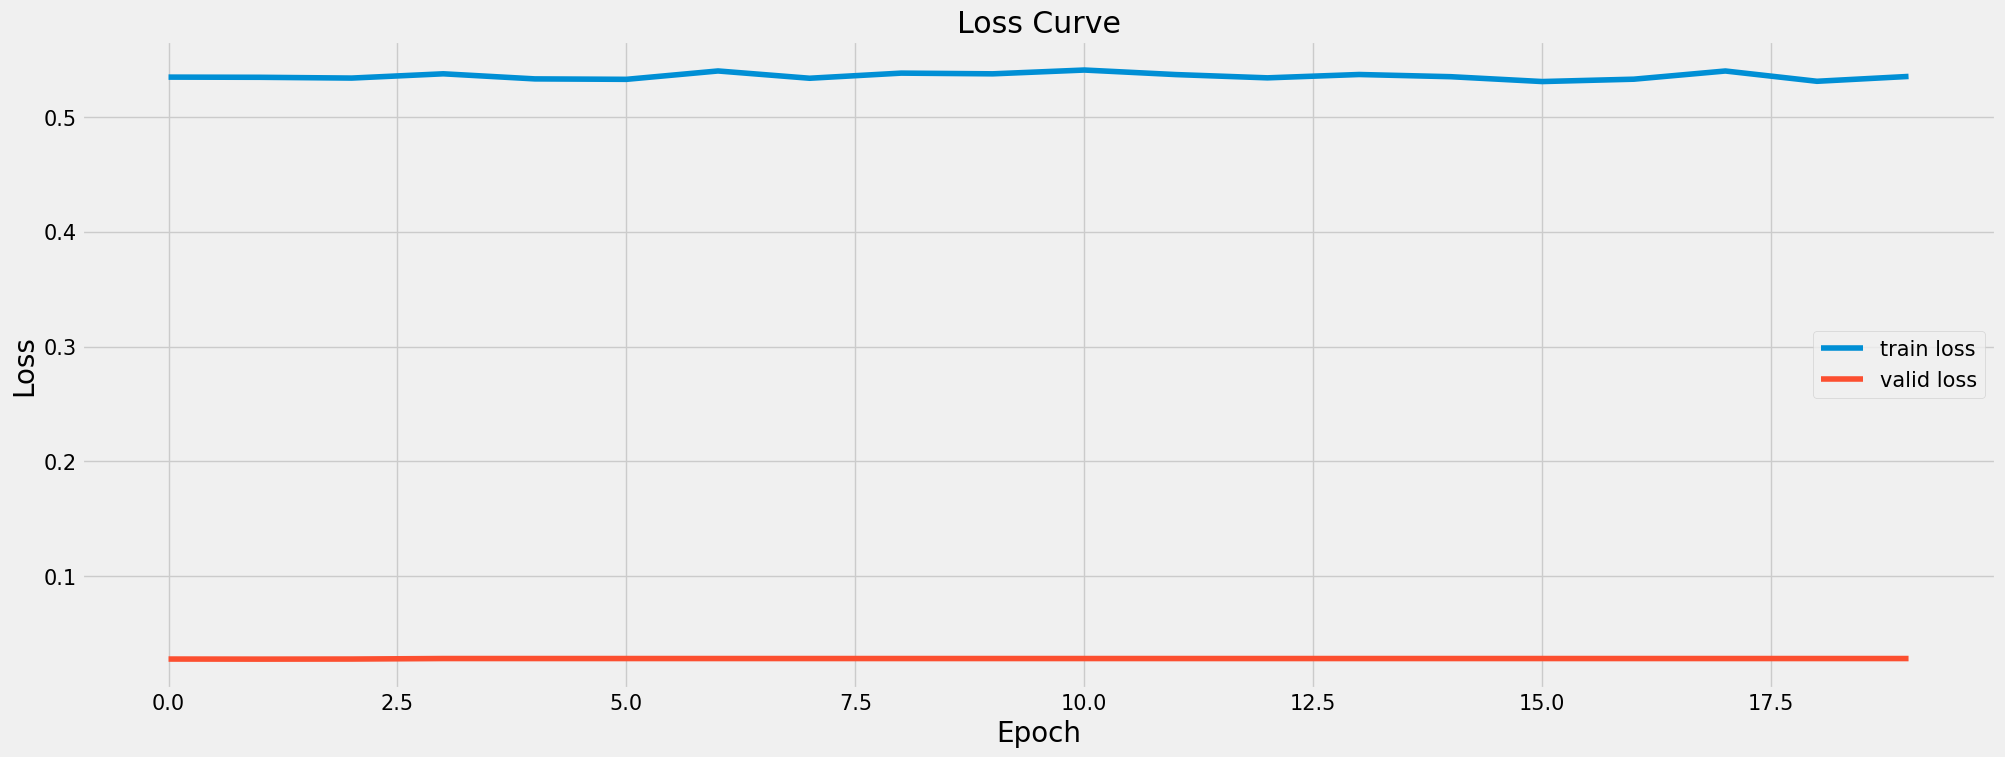

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22,8))
epochs = list(range(20))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

In [21]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [20]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,1,"classification")
unet_model = unet_model.to(device)

optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

In [32]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  

            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, slope, labels in dataloaders[phase]:
                images = images.to(device)
                seg = seg.to(device)
                slope = slope.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images, slope)
                    loss_seg = criterion_seg(outputs, torch.unsqueeze(seg.float(), dim=1))
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, torch.unsqueeze(seg.float(), dim=1))
                running_acc_seg += m_avg
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()
                
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc Seg: {:.4f} Acc Class: {:.4f}'.format(
                phase, epoch_loss, epoch_acc_seg, epoch_acc_class))
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc_class > best_acc:
                best_acc = epoch_acc_class
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [33]:
unet_classifier_segmentation = train_model(unet_model, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.0497 Acc Seg: 0.5000 Acc Class: 0.8417
val Loss: 3.1654 Acc Seg: 0.5000 Acc Class: 0.3187
Epoch 2/15
----------
train Loss: 1.0438 Acc Seg: 0.5000 Acc Class: 0.8376
val Loss: 3.4075 Acc Seg: 0.5000 Acc Class: 0.3063
Epoch 3/15
----------
train Loss: 1.0180 Acc Seg: 0.5000 Acc Class: 0.8597
val Loss: 3.3089 Acc Seg: 0.5000 Acc Class: 0.3521
Epoch 4/15
----------
train Loss: 0.9964 Acc Seg: 0.5000 Acc Class: 0.8699
val Loss: 1.8943 Acc Seg: 0.5000 Acc Class: 0.3479
Epoch 5/15
----------
train Loss: 0.9362 Acc Seg: 0.5000 Acc Class: 0.8781
val Loss: 2.8715 Acc Seg: 0.5000 Acc Class: 0.3375
Epoch 6/15
----------
train Loss: 0.7442 Acc Seg: 0.5000 Acc Class: 0.8166
val Loss: 2.5438 Acc Seg: 0.5000 Acc Class: 0.3250
Epoch 7/15
----------
train Loss: 0.3434 Acc Seg: 0.5000 Acc Class: 0.8420
val Loss: 2.7658 Acc Seg: 0.5000 Acc Class: 0.3396
Epoch 8/15
----------
train Loss: 0.2422 Acc Seg: 0.5000 Acc Class: 0.8611
val Loss: 2.8621 Acc Seg: 0.5000 Acc Class:

In [26]:
print(acc_class_dict)
print(acc_seg_dict)
print(loss_dict)

{'train': [0.04096663688526716, 0.043848674418779224, 0.04771745607616435, 0.05005585345122514, 0.05373473340001247, 0.051724009539422654, 0.05024947870832346, 0.053842716722002616, 0.05462466487935657, 0.055008191845052685, 0.05550342568123948, 0.057380101284456635, 0.05636729222520107, 0.05650878761153438, 0.05825886208633955], 'val': [0.021727467811158797, 0.023068669527896997, 0.022666309012875537, 0.023202789699570816, 0.021593347639484978, 0.0210568669527897, 0.02132510729613734, 0.019447424892703864, 0.022129828326180257, 0.021727467811158797, 0.021995708154506438, 0.021727467811158797, 0.022800429184549355, 0.018776824034334765, 0.022129828326180257]}
{'train': [0.023850347952612604, 0.031135820879054133, 0.03136622926504938, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107, 0.03136729222520107], 'va

In [27]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

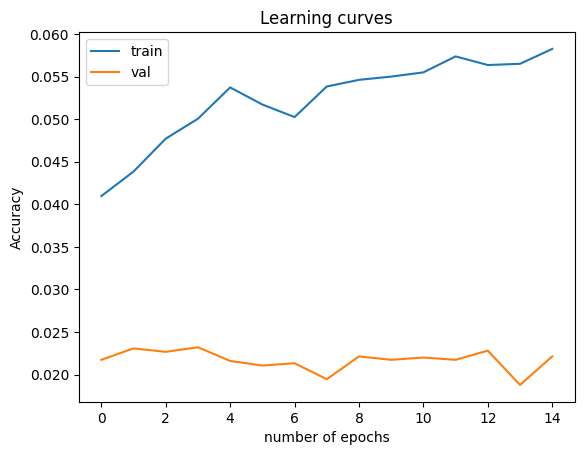

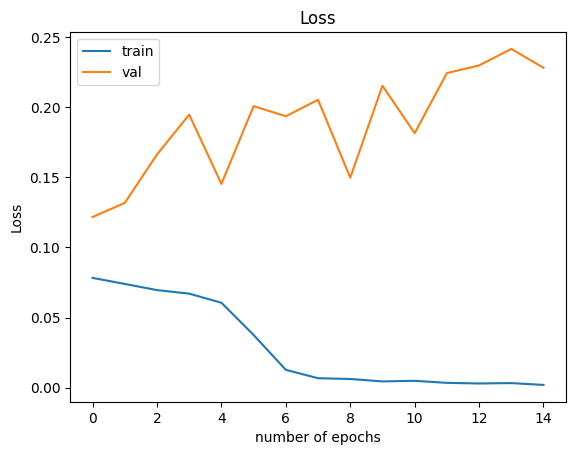

In [28]:
show_curves(acc_class_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

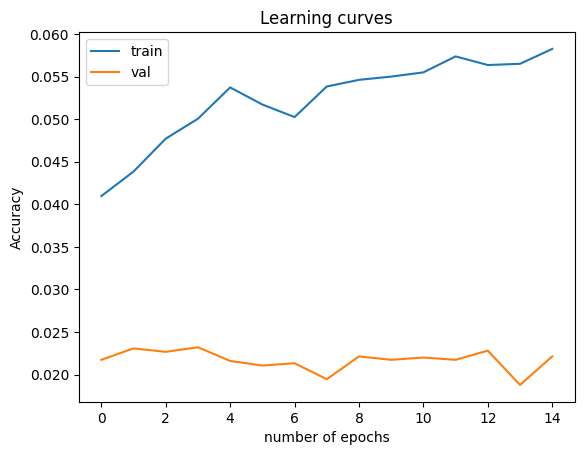

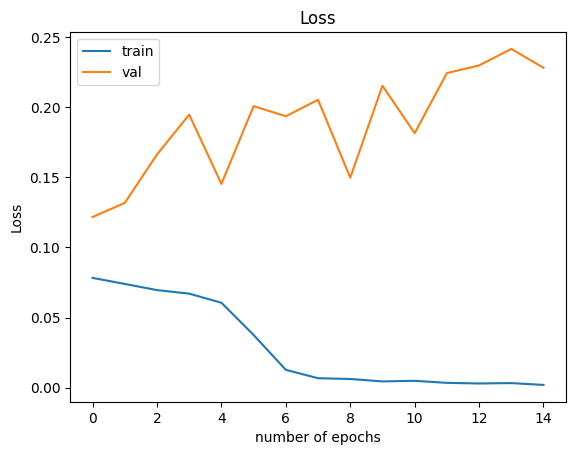

In [29]:
show_curves(acc_class_dict, loss_dict)

In [30]:
def test(model): 
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, slope, labels in testloader: 
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images, slope)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader)))  

In [31]:
test(unet_classifier_segmentation)

Accuracy of the model based on the test set is: 11 %
